# Connecting to google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Training GoogLeNet model on WGAN-GP augmented data

<b> Lets check the specs of my GPU on which this model has been trained on.

In [2]:
!nvidia-smi

Thu Dec  8 14:00:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing the dependencies

In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Loading training, validation and testing dataset

In [4]:
train_data_dir = r"/content/gdrive/MyDrive/FYP Training Models/Covid-19 Dataset/Train"
validation_data_dir = r"/content/gdrive/MyDrive/FYP Training Models/Covid-19 Dataset/Validation"
test_data_dir = r"/content/gdrive/MyDrive/FYP Training Models/Covid-19 Dataset/Test"

In [5]:
n_classes = os.listdir(train_data_dir)
print("The total number of classes present in the dataset are: ", n_classes)

The total number of classes present in the dataset are:  ['Covid', 'Normal', 'Viral Pneumonia']


## Looking at some individual samples from training data

In [6]:
from PIL import Image
from PIL import Image
import glob
import random
from tqdm import tqdm

Covid


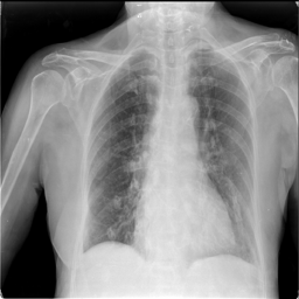

In [ ]:
# loading the first sample from Covid class

covid_sample1 = os.listdir(train_data_dir+'/Covid')[0]
covid_sample1 = os.path.join(train_data_dir+"/Covid", covid_sample1)

print("Covid")
Image.open(covid_sample1)

Normal


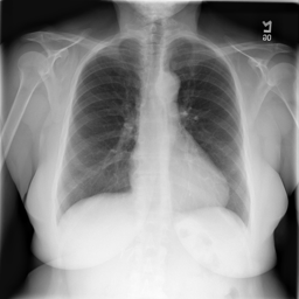

In [ ]:
# loading the first sample from Normal class

normal_sample1 = os.listdir(train_data_dir+r'/Normal')[0]
normal_sample1 = os.path.join(train_data_dir+r"/Normal", normal_sample1)

print("Normal")
Image.open(normal_sample1)

Viral Pneumonia


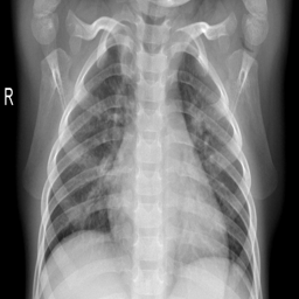

In [ ]:
# loading the first sample from Viral Pneumonia class

pneumonia_sample1 = os.listdir(train_data_dir+r'/Viral Pneumonia')[0]
pneumonia_sample1 = os.path.join(train_data_dir+r"/Viral Pneumonia", pneumonia_sample1)

print("Viral Pneumonia")
Image.open(pneumonia_sample1)

## Performing preprocessing on training, validation and testing images

Since I will be training 3 GAN architectures, DCGAN, WGAN, and WGAN-GP, on 1 * 64 * 64 images, I will need to resize all my images to same dimension in order to compare the performance of the model accross all datasets. However, the model I have selected, <b> ResNet-50 </b> takes an input image of 3 * 224 * 244. The number of channels can be changed to 1 in the input layer indicating that the model takes in greyscale image. However, we have two options related to the input image dimensions:

    1. Delete/Modify original model such that the initial layers take in 64 * 64 images.
    2. Or, perform zero-padding on all training images and convert their dimensions from 1 * 64 * 64 to 1 * 224 * 224.
    
    
I must also note that after generating 1 * 64 * 64 images from GANs, I would need to perform same padding on those images to match the dimensions. This way, we can fairly compare the performance of <b> ResNet-50 </b> accross 


    1. Imbalanced data
    2. Data with traditional augmentation
    3. Data with DCGAN augmentation
    4. Data with WGAN augmentation
    5. Data with WGAN-GP augmentation

### Creating a new dataset such that the minority class has equal number of samples as majority class through WGAN-GP augmentation

In our training dataset, our classes have following sample counts:

  1. Covid (2816 samples)
  2. Normal (9392)
  3. Viral Pneumonia (545)


  <b>This means that for Covid class, we need to add 9392 - 2816 = 6576 number of new samples. </b>





<b> For Viral Pneumonia class, we need to add 9392 - 545 = 8847 number of new samples. </b>

In [7]:
# creating the train dataset and dataloader for calculating the mean and standard deviation of our samples
image_size = 64
batch_size = 100
CHANNELS_IMG = 1

In [ ]:
train_ds_original = ImageFolder(train_data_dir, transform=tt.Compose([
                                        tt.Grayscale(num_output_channels=1),
                                        tt.Resize(image_size),
                                        tt.ToTensor()]))

In [ ]:
len(train_ds_original)

12753

<b> Creating custom PyTorch dataset with augmentation on images of Covid and Viral Pneumonia class using DCGAN

In [8]:
device = 'cpu'
n_classes = 2
latent_size = 100
generator_input_dim = 103
CHANNELS_IMG = 1
stats_gen = [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
# classes = ['COVID','Viral Pneumonia']

def denorm(img_tensors):
    return img_tensors * stats_gen[1][0] + stats_gen[0][0]


''' FOR 64 * 64 Image Generation '''
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    # generator_input_dim * 1 * 1 -> done
    nn.ConvTranspose2d(102, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # out: 512 x 4 x 4 -> done

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 1 x 64 x 64
)


generator.load_state_dict(torch.load('cWGANGP_generator.pth', map_location ='cpu'))
generator.eval()
latent_size = 100
generator_input_dim = 102

In [9]:
def get_an_image(class_, noise):
  label = torch.tensor([class_ for i in range(noise.shape[0])])
  one_hot_labels = F.one_hot(label.to(device), n_classes)

  # concatenating noise vector with one hot encoded vector containing label information
  noise_and_labels = torch.cat([noise, one_hot_labels.float()],dim=1)
  noise_and_labels = noise_and_labels.view(len(noise_and_labels), generator_input_dim, 1, 1)
  fake_images = denorm(generator(noise_and_labels))
  
  return fake_images.detach().to('cpu')

In [10]:
%%time

torch.manual_seed(42)
noise_Covid = torch.randn(6576, 100, device='cpu')
covid_generated_by_DCGAN = get_an_image(0, noise_Covid)
covid_generated_by_DCGAN = [(i, 0) for i in covid_generated_by_DCGAN]

CPU times: user 44.4 s, sys: 3.1 s, total: 47.5 s
Wall time: 51 s


In [11]:
%%time

torch.manual_seed(84)
noise_Pneumonia = torch.randn(8847, 100, device='cpu')
Pneumonia_generated_by_DCGAN = get_an_image(1, noise_Pneumonia)
Pneumonia_generated_by_DCGAN = [(i, 2) for i in Pneumonia_generated_by_DCGAN]

CPU times: user 53.7 s, sys: 2.16 s, total: 55.9 s
Wall time: 55.8 s


In [ ]:
class DCGANDataset(Dataset):
    def __init__(self, covid_dcgan, pneumonia_dcgan):
      self.covid_dcgan = covid_dcgan
      self.pneumonia_dcgan = pneumonia_dcgan


      self.data = self.covid_dcgan + self.pneumonia_dcgan
      print("Data shape: ", len(self.data))
                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, class_id = self.data[idx]
        
        return img, class_id

In [ ]:
covid_plus_pneumonia_DCGAN_Dataset = DCGANDataset(covid_generated_by_DCGAN, Pneumonia_generated_by_DCGAN)

Data shape:  15423


In [ ]:
concatenated_ds = torch.utils.data.ConcatDataset([train_ds_original, covid_plus_pneumonia_DCGAN_Dataset])
concatenated_dl = DataLoader(concatenated_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
len(concatenated_ds)

28176

### Calculating mean and standard deviation of the channels of our training dataset

We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(dataloader):
        
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
mean, std = get_mean_and_std(concatenated_dl)

100%|██████████| 282/282 [25:42<00:00,  5.47s/it]


In [ ]:
print("The calculated mean is: ", mean)
print("The calculated standard deviation is: ", std)

The calculated mean is:  tensor([0.5199])
The calculated standard deviation is:  tensor([0.2488])


### Creating datasets and dataloaders with normalization and zero-padding

In [12]:
mean = 0.5199
std = 0.2488

stats = [mean for _ in range(CHANNELS_IMG)], [std for _ in range(CHANNELS_IMG)];stats

([0.5199], [0.2488])

In [13]:
'''---------------------------------- Original Dataset ------------------------------ '''
class OriginalDataset(Dataset):
    def __init__(self, data_dir, stats):

      self.stats = stats        
      self.available_classes = os.listdir(data_dir)
      self.data = []
      self.transform = tt.Compose([tt.Grayscale(num_output_channels=1), tt.Resize(64), tt.ToTensor(), tt.Normalize(*self.stats)])
      self.targets = []
  
      class_list = os.listdir(data_dir) # ['Covid', 'Normal', 'Viral Pneumonia']
      for class_name in class_list:
          class_path = os.path.join(data_dir, class_name)
          for img_path in glob.glob(class_path + "/*.png"):
              self.data.append([img_path, class_name])

                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = self.transform(Image.open(img_path))        
        class_id = self.available_classes.index(class_name)

        grey_image = np.zeros([1, 224, 224], dtype = np.float64)
        grey_image[:,80:144, 80:144] = img
        grey_image = torch.from_numpy(grey_image)
        grey_image = grey_image.type(torch.FloatTensor)
        
        return grey_image, class_id



''' ----------------------------------- DCGAN DATASET ------------------------------------- '''

class DCGANDataset(Dataset):
    def __init__(self, covid_dcgan, pneumonia_dcgan, stats):
      
      self.stats = stats
      self.covid_dcgan = covid_dcgan
      self.pneumonia_dcgan = pneumonia_dcgan
      self.data = [*self.covid_dcgan, *self.pneumonia_dcgan]
                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, class_id = self.data[idx]
        
        # tt.Normalize(*self.stats)]
        img = tt.Normalize(*self.stats)(img)        
        grey_image = np.zeros([1, 224, 224], dtype = np.float64)
        grey_image[:,80:144, 80:144] = img
        grey_image = torch.from_numpy(grey_image)
        grey_image = grey_image.type(torch.FloatTensor)
        
        return grey_image, class_id
        



'''---------------------------------- CREATING TRAINING DATASET AND DATALOADER ----------------------------'''

Original_Dataset = OriginalDataset(train_data_dir, stats)
DCGAN_Dataset = DCGANDataset(covid_generated_by_DCGAN, Pneumonia_generated_by_DCGAN, stats)

train_ds = torch.utils.data.ConcatDataset([Original_Dataset, DCGAN_Dataset])
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [14]:
class Test_And_Val_Datasets(Dataset):
    def __init__(self, data_dir, transforms):
        self.data = []
        self.transform = transforms
        self.targets = []
    
        class_list = os.listdir(data_dir) # ['Covid', 'Normal', 'Viral Pneumonia']
        for class_name in class_list:
            class_path = os.path.join(data_dir, class_name)
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, class_name])
                
        self.available_classes = os.listdir(data_dir)
                        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = self.transform(Image.open(img_path))
        grey_image = np.zeros([1, 224, 224], dtype = np.float64)
        grey_image[:,80:144, 80:144] = img
        grey_image = torch.from_numpy(grey_image)
        grey_image = grey_image.type(torch.FloatTensor)

        
        class_id = self.available_classes.index(class_name)       
        return grey_image, class_id

In [15]:
# following transformations will be performed on each image
transformations_to_perform =  tt.Compose([
                                tt.Grayscale(num_output_channels=1),
                                tt.Resize(image_size),
                                tt.ToTensor(),
                                tt.Normalize(*stats)])

# Validation dataset
val_ds = Test_And_Val_Datasets(validation_data_dir, transformations_to_perform)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)


# # Test dataset
test_ds = Test_And_Val_Datasets(test_data_dir, transformations_to_perform)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [16]:
# custom function for denormalizing normalized images 

def denorm(img_tensors):
    img = img_tensors[:,80:144, 80:144] 
    img = img * stats[1][0] + stats[0][0]
    img_tensors[:,80:144, 80:144]  = img
    return img_tensors

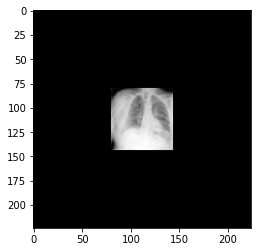

In [ ]:
# Padded image 1
# print(train_ds[1000][0])
plt.imshow(denorm(train_ds[15000][0])[0], cmap ='gray')

# Using a GPU

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
# transporting training, validation and testing dataloaders to GPU

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Importing GoogLeNet Model

In [20]:
from GoogLeNet import InceptionNet, Inception_block, InceptionAux, conv_block

In [21]:
model = InceptionNet()
model = to_device(model, device)

# Training our model

In [24]:
from tqdm import tqdm

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
%%time

history = [evaluate(model, val_dl)]
history

CPU times: user 3.29 s, sys: 1.55 s, total: 4.84 s
Wall time: 1min 28s


[{'val_loss': 1.0986218452453613, 'val_acc': 33.33333206176758}]

In [28]:
epochs = 20
max_lr = 0.0001
grad_clip = 0.1 
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [29]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip = grad_clip, 
                             weight_decay = weight_decay, 
                             opt_func = opt_func)

100%|██████████| 282/282 [22:53<00:00,  4.87s/it]


Epoch [0], last_lr: 0.00001, train_loss: 0.6125, val_loss: 0.5551, val_acc: 76.1667


100%|██████████| 282/282 [01:51<00:00,  2.53it/s]


Epoch [1], last_lr: 0.00003, train_loss: 0.1775, val_loss: 0.5787, val_acc: 77.0000


100%|██████████| 282/282 [01:51<00:00,  2.52it/s]


Epoch [2], last_lr: 0.00005, train_loss: 0.1118, val_loss: 0.7667, val_acc: 73.6667


100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch [3], last_lr: 0.00008, train_loss: 0.0887, val_loss: 0.2420, val_acc: 91.0833


100%|██████████| 282/282 [01:50<00:00,  2.54it/s]


Epoch [4], last_lr: 0.00009, train_loss: 0.0787, val_loss: 0.9255, val_acc: 71.0833


100%|██████████| 282/282 [01:51<00:00,  2.53it/s]


Epoch [5], last_lr: 0.00010, train_loss: 0.0649, val_loss: 0.3692, val_acc: 86.3333


100%|██████████| 282/282 [01:50<00:00,  2.54it/s]


Epoch [6], last_lr: 0.00010, train_loss: 0.0494, val_loss: 0.6577, val_acc: 79.3333


100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch [7], last_lr: 0.00010, train_loss: 0.0399, val_loss: 0.2350, val_acc: 92.0000


100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch [8], last_lr: 0.00009, train_loss: 0.0325, val_loss: 0.2908, val_acc: 92.2500


100%|██████████| 282/282 [01:51<00:00,  2.53it/s]


Epoch [9], last_lr: 0.00008, train_loss: 0.0269, val_loss: 0.4090, val_acc: 87.6667


100%|██████████| 282/282 [01:50<00:00,  2.54it/s]


Epoch [10], last_lr: 0.00007, train_loss: 0.0174, val_loss: 0.4932, val_acc: 87.6667


100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch [11], last_lr: 0.00006, train_loss: 0.0145, val_loss: 0.2163, val_acc: 94.2500


100%|██████████| 282/282 [01:51<00:00,  2.53it/s]


Epoch [12], last_lr: 0.00005, train_loss: 0.0077, val_loss: 0.3354, val_acc: 91.6667


100%|██████████| 282/282 [01:51<00:00,  2.52it/s]


Epoch [13], last_lr: 0.00004, train_loss: 0.0050, val_loss: 0.2973, val_acc: 92.8333


100%|██████████| 282/282 [01:51<00:00,  2.53it/s]


Epoch [14], last_lr: 0.00003, train_loss: 0.0036, val_loss: 0.2360, val_acc: 94.0000


100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch [15], last_lr: 0.00002, train_loss: 0.0012, val_loss: 0.2780, val_acc: 94.0000


100%|██████████| 282/282 [01:51<00:00,  2.54it/s]


Epoch [16], last_lr: 0.00001, train_loss: 0.0010, val_loss: 0.2629, val_acc: 95.0833


100%|██████████| 282/282 [01:51<00:00,  2.52it/s]


Epoch [17], last_lr: 0.00000, train_loss: 0.0006, val_loss: 0.3048, val_acc: 93.8333


100%|██████████| 282/282 [01:51<00:00,  2.53it/s]


Epoch [18], last_lr: 0.00000, train_loss: 0.0004, val_loss: 0.2968, val_acc: 94.1667


100%|██████████| 282/282 [01:51<00:00,  2.52it/s]


Epoch [19], last_lr: 0.00000, train_loss: 0.0004, val_loss: 0.2822, val_acc: 94.0833
CPU times: user 21min 6s, sys: 14min 41s, total: 35min 47s
Wall time: 59min 37s


In [30]:
import pandas as pd

In [34]:
import pickle

with open('GoogLeNet_history_WGANGP.pkl', 'wb') as f:
   pickle.dump(history, f)

In [31]:
torch.save(model.state_dict(), 'GoogLeNet_WGANGP.pth')

In [32]:
!cp '/content/GoogLeNet_WGANGP.pth' '/content/gdrive/MyDrive/FYP Training Models'

In [33]:
!cp '/content/GoogLeNet_history_WGANGP.pkl' '/content/gdrive/MyDrive/FYP Training Models'

cp: cannot stat '/content/GoogLeNet_history_WGANGP.pkl': No such file or directory
